In [37]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import arviz
import pandas as pd
import random
from scipy.stats import lognorm
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive
assert pyro.__version__.startswith('1.8.4')
pyro.set_rng_seed(1)

In [25]:
pyro.clear_param_store()

In [27]:
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)

In [28]:
# Data
X = torch.tensor([-1, -0.5, 0, 0.5, 1])
y = f(X)

In [29]:
# Params given in question
lengthscaleDist = dist.LogNormal(torch.tensor(-1.), torch.tensor(1.))
varianceDist = dist.LogNormal(torch.tensor(0.), torch.tensor(2.))
noise = torch.tensor(10**(-4))

In [30]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(1)
kernel.variance = pyro.nn.PyroSample(varianceDist)
kernel.lengthscale = pyro.nn.PyroSample(lengthscaleDist)
gpr = gp.models.GPRegression(X, y, kernel, noise= noise)

In [42]:
# 10 warm up steps for tuning
pyro.clear_param_store()
nuts_kernel=NUTS(gpr.model, adapt_step_size=True)
nuts_kernel.cleanup()
mcmc=MCMC(nuts_kernel, num_samples=1000, num_chains=4, warmup_steps=100)
mcmc.run()

Warmup [1]:   0%|          | 0/1100 [00:00, ?it/s]





Warmup [1]:   0%|          | 1/1100 [00:03,  3.92s/it, step size=2.25e-01, acc. prob=1.000]


Warmup [1]:   1%|▏         | 14/1100 [00:04,  6.32it/s, step size=6.04e-01, acc. prob=0.831]




Warmup [1]:   2%|▏         | 23/1100 [00:04, 11.86it/s, step size=2.50e-01, acc. prob=0.807]



Warmup [1]:   3%|▎         | 28/1100 [00:04, 15.59it/s, step size=7.52e-02, acc. prob=0.791]




Warmup [1]:   3%|▎         | 36/1100 [00:05, 20.21it/s, step size=2.11e-01, acc. prob=0.803]





Warmup [1]:   4%|▍         | 42/1100 [00:05, 22.94it/s, step size=1.11e-01, acc. prob=0.797]

Warmup [1]:   4%|▍         | 46/1100 [00:05, 25.30it/s, step size=2.97e-01, acc. prob=0.806]

Warmup [1]:   5%|▍         | 51/1100 [00:05, 29.97it/s, step size=6.74e-01, acc. prob=0.812]


Warmup [1]:   5%|▌         | 59/1100 [00:05, 26.88it/s, step size=4.58e-01, acc. prob=0.808]




Warmup [1]:   6%|▌         | 63/1100 [00:05, 27.26it/s, step size=2.54e-01, acc. p

In [43]:
# Arviz
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary) # because we only used one chain, r_hat cannot be evauated.
plt.show()

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.313  0.180   0.030    0.632      0.006    0.004   
kernel.variance     4.577  4.706   0.613   11.276      0.166    0.117   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     945.0    1397.0    1.0  
kernel.variance       1227.0     774.0    1.0  


c:\Users\deniz\AppData\Local\Programs\Python\Python38\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


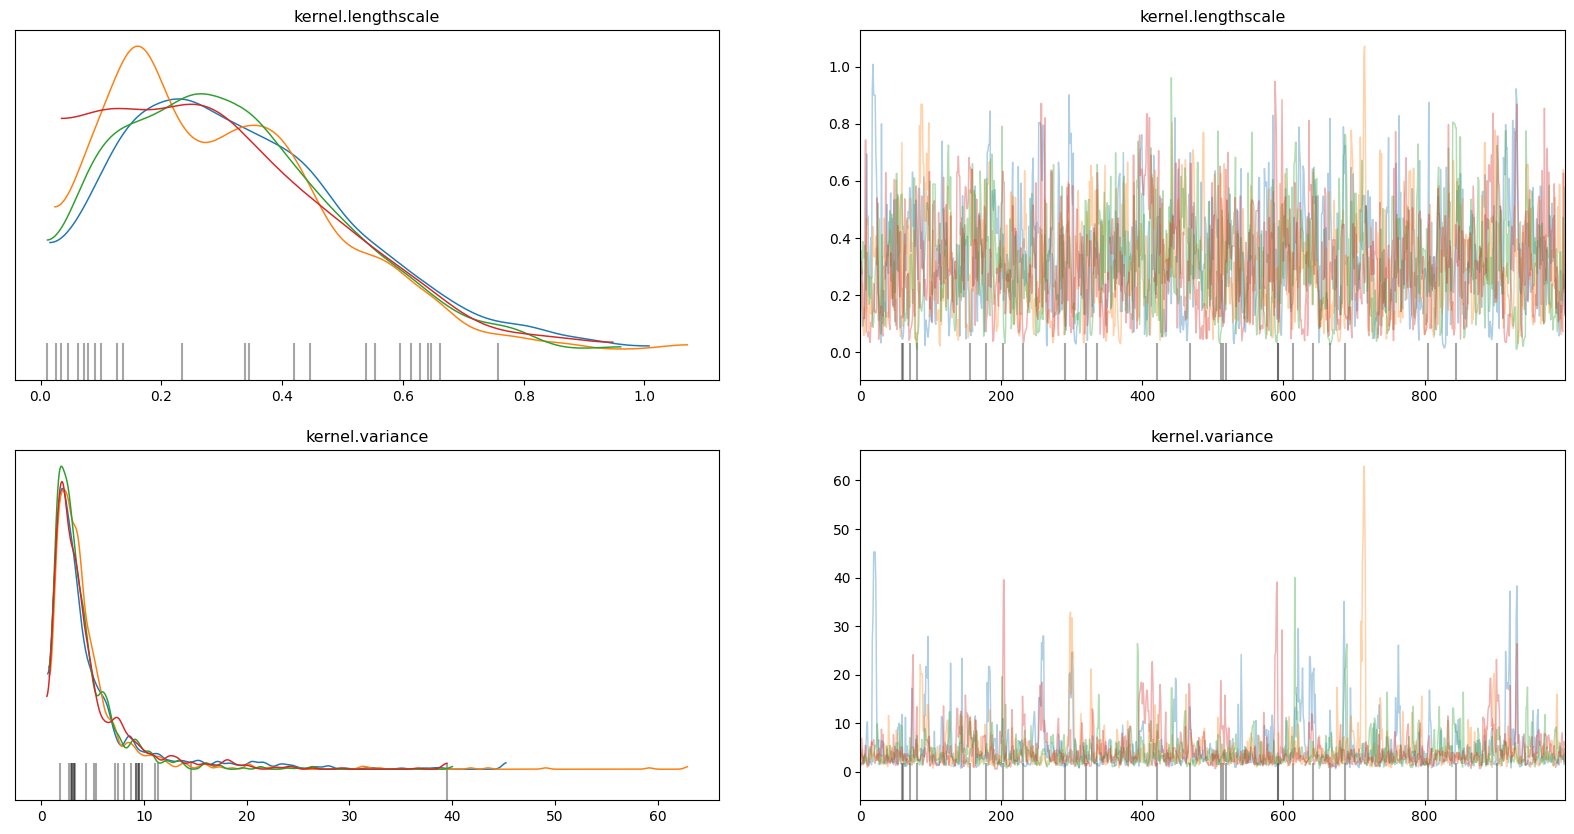

In [44]:
# Tuning trace plots
axes = arviz.plot_trace(data, kind="trace",compact=False, figsize=(20,10))
fig = axes.ravel()[0].figure
fig.savefig("trace_tune.png")

Text(0, 0.5, 'log variance')

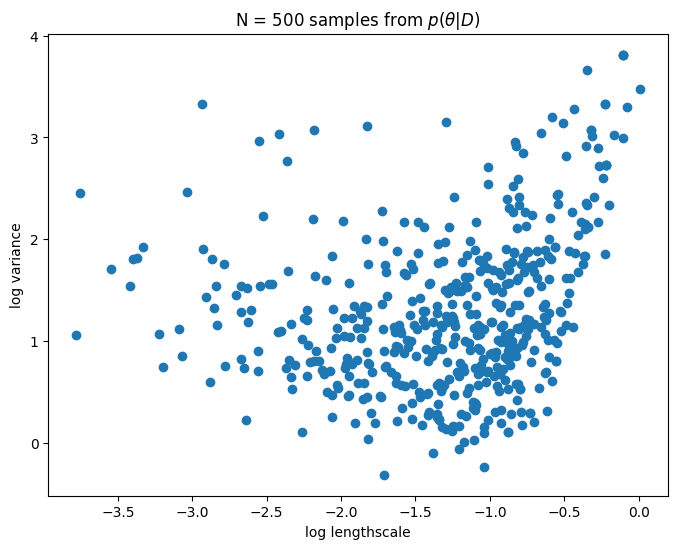

In [113]:
# Log-log plot
ls = mcmc.get_samples()['kernel.lengthscale']
v = mcmc.get_samples()['kernel.variance']

plt.subplots(figsize =(8, 6))
plt.scatter(np.log(ls[0:500]), np.log(v[0:500]))
plt.title("N = 500 samples from $p(\\theta \\vert D)$")
plt.xlabel("log lengthscale")
plt.ylabel("log variance")

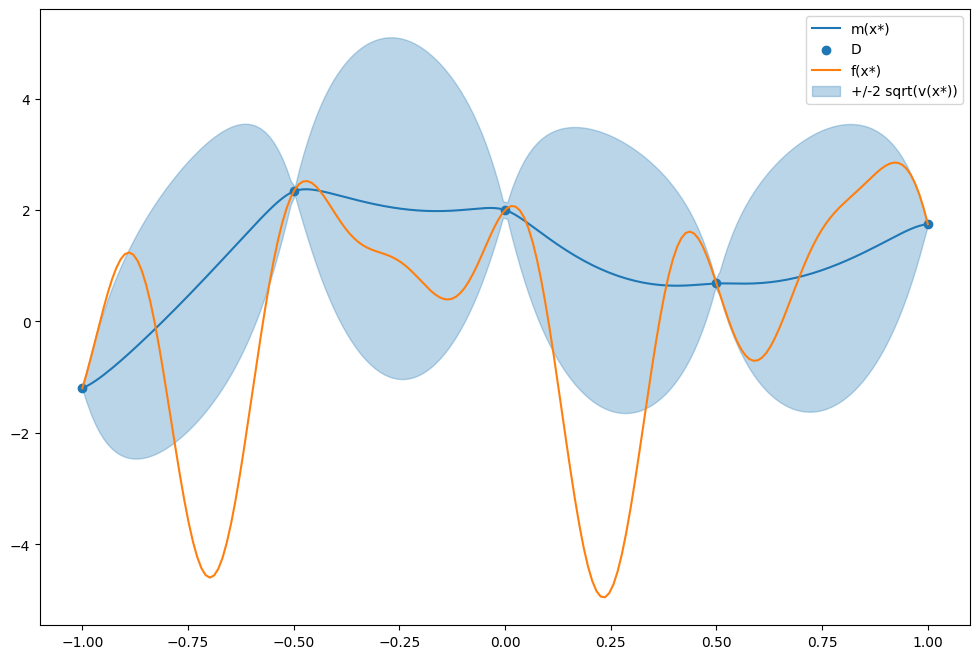

In [117]:
x_test = torch.linspace(-1.0, 1.0, 200)
y_test = f(x_test)

locs = []
covs = torch.zeros(x_test.size())
for i in range(len(ls)):
    pyro.clear_param_store()
    kernel_temp = gp.kernels.RBF(input_dim=1)
    kernel_temp.variance = v[i]
    kernel_temp.lengthscale = ls[i]
    iter_gpr = gp.models.GPRegression(X, y, kernel_temp, noise = noise)

    loc, cov = iter_gpr(x_test)
    locs.append(loc.detach().numpy())
    covs = covs + cov

locs = np.array(locs)
meanOfMeans = [np.mean(locs[:,i]) for i in range(len(locs[0]))]
variationOfMeans = np.sum((locs - meanOfMeans)**2, axis=0) / len(locs)
meanOfVars = (covs / len(ls)).detach().numpy()
fullVar = meanOfVars + variationOfMeans

plt.subplots(figsize=(12, 8))
plt.plot(x_test, meanOfMeans, label = "m(x*)")
plt.scatter(X, y, label ="D")
plt.plot(x_test, f(x_test), label = "f(x*)")
plt.fill_between(
    x_test,  # plot the two-sigma uncertainty about the mean
    (meanOfMeans - 2.0 * np.sqrt(fullVar)),
    (meanOfMeans + 2.0 * np.sqrt(fullVar)),
    color="C0",
    alpha=0.3,
    label = "+/-2 sqrt(v(x*))"
)
plt.legend()

# B2

In [118]:
Xstar = torch.linspace(-1.0, 1.0, 200)

In [ ]:
# Draw sample from posterior
ls = mcmc.get_samples()['kernel.lengthscale']
v = mcmc.get_samples()['kernel.variance']
unif = random.randrange(len(ls))
fstar_ls = ls[unif]
fstar_v = v[unif]
print(fstar_ls, fstar_v)

tensor(0.2203) tensor(1.8349)


In [150]:
def BOA2(iter):
    Xt = X
    yt = y
    mcmct = mcmc
    for i in range(iter):
        pyro.clear_param_store()

        # Posterior samples
        ls = mcmct.get_samples()['kernel.lengthscale']
        v = mcmct.get_samples()['kernel.variance']

        # Draw a sample theta
        unif = random.randrange(len(ls))
        fstar_ls = ls[unif]
        fstar_v = v[unif]
        
        kernel_iter = gp.kernels.RBF(input_dim=1, variance=fstar_v, lengthscale=fstar_ls)
        posteriorPredictive = gp.models.GPRegression(Xt, yt, kernel_iter, noise=noise)

        # Using X2t to avoid previous mins
        f_loc, f_cov = posteriorPredictive(Xstar, full_cov = True)
        fstar = np.random.multivariate_normal(f_loc.detach().numpy(), f_cov.detach().numpy())
        val= fstar.min()
        ind = fstar.argmin()
        print(val, Xstar[ind])

        # Parameters for multivariate normal
        # Using X2 for all points
        # f_loc, f_cov = posteriorPredictive(Xstar, full_cov = True)
        # fstar = np.random.multivariate_normal(f_loc.detach().numpy(), f_cov.detach().numpy())

        
        if i % 5 == 0:
            # Plot f, f*
            plt.subplots(figsize = (12, 8))
            plt.scatter(Xstar[ind], f(Xstar[ind]), label ="($x_p^*, f(x_p^*)$")
            plt.plot(Xstar, f(Xstar), label = "$f(x^*)$")
            plt.plot(Xstar, fstar, label="$f^*(x^*)$")


            # Like earlier, integrate out theta
            locs = []
            covs = torch.zeros(Xstar.size())
            for j in range(len(ls)):
                pyro.clear_param_store()
                kernel_temp2 = gp.kernels.RBF(input_dim=1)
                kernel_temp2.variance = v[j]
                kernel_temp2.lengthscale = ls[j]
                iter2_gpr = gp.models.GPRegression(Xt, yt, kernel_temp2, noise = noise)

                loc, cov = iter2_gpr(Xstar)
                locs.append(loc.detach().numpy())
                covs = covs + cov
            
            # calculate m and v
            locs = np.array(locs)
            meanOfMeans = [np.mean(locs[:,k]) for k in range(len(locs[0]))]
            variationOfMeans = np.sum((locs - meanOfMeans)**2, axis=0) / len(locs)
            meanOfVars = (covs / len(ls)).detach().numpy()
            fullVar = meanOfVars + variationOfMeans

            # Add plot of m +-2*sqrt(v)
            plt.plot(Xstar, meanOfMeans, label = "$m(x^*)$")
            plt.fill_between(
                x_test,  # plot the two-sigma uncertainty about the mean
                (meanOfMeans - 2.0 * np.sqrt(fullVar)),
                (meanOfMeans + 2.0 * np.sqrt(fullVar)),
                color="C0",
                alpha=0.3,
                label = "$\\pm2 \\sqrt{v(x^*)}$"
            )
            plt.title(f"k = {i}")
            plt.legend()
            plt.show()

        
        Xt = torch.cat((Xt, torch.tensor([Xstar[ind]])))
        yt = torch.cat((yt, torch.tensor([f(Xstar[ind])])))

        kernelt = gp.kernels.RBF(1)
        kernelt.variance = pyro.nn.PyroSample(varianceDist)
        kernelt.lengthscale = pyro.nn.PyroSample(lengthscaleDist)
        gprt = gp.models.GPRegression(Xt, yt, kernel, noise = noise)

        # 10 warm up steps for tuning
        pyro.clear_param_store()
        nuts_kernelt=NUTS(gprt.model, adapt_step_size=True)
        nuts_kernelt.cleanup()
        mcmct=MCMC(nuts_kernelt, num_samples=200, num_chains=1, warmup_steps=50)
        mcmct.run()

C:\Users\deniz\AppData\Local\Temp\ipykernel_18932\1558241411.py:22: RuntimeWarning: covariance is not positive-semidefinite.
  fstar = np.random.multivariate_normal(f_loc.detach().numpy(), f_cov.detach().numpy())


-1.1812888584648764 tensor(-1.)


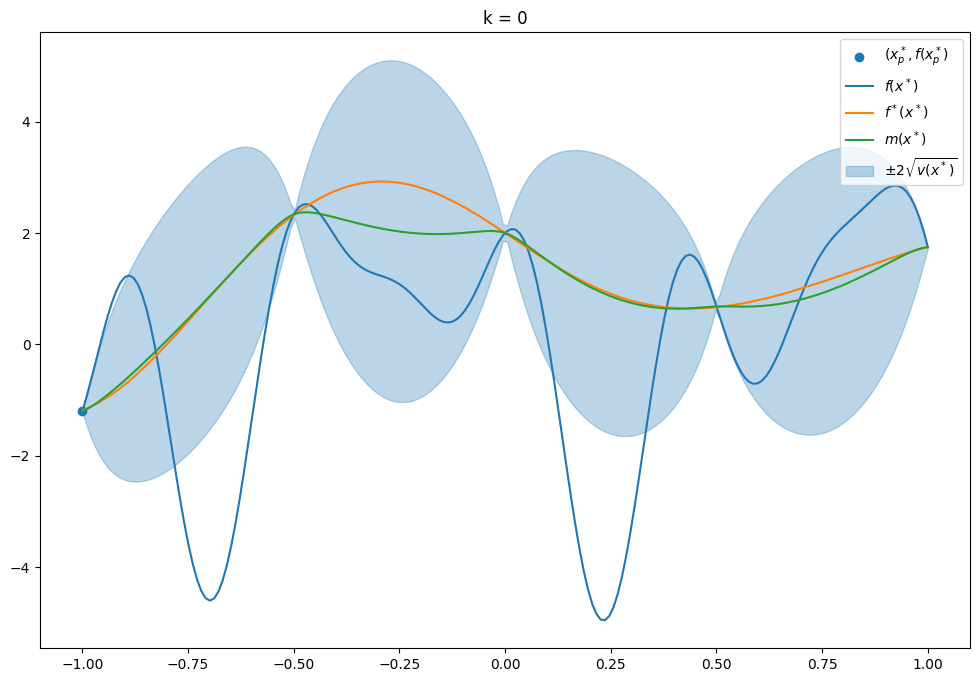

Sample: 100%|██████████| 250/250 [00:05, 44.85it/s, step size=5.76e-01, acc. prob=0.841]


-1.2047053066332334 tensor(-1.)


Sample: 100%|██████████| 250/250 [00:05, 46.98it/s, step size=5.85e-01, acc. prob=0.799]


-1.197176780087698 tensor(-1.)


Sample: 100%|██████████| 250/250 [00:07, 35.32it/s, step size=4.15e-01, acc. prob=0.895]


-1.2040738512819218 tensor(-1.)


Sample: 100%|██████████| 250/250 [00:04, 62.04it/s, step size=1.05e+00, acc. prob=0.475]


-1.2032605783776669 tensor(-0.9899)


Sample: 100%|██████████| 250/250 [00:22, 11.30it/s, step size=1.14e-01, acc. prob=0.960]


-3.2027356606310042 tensor(0.1156)


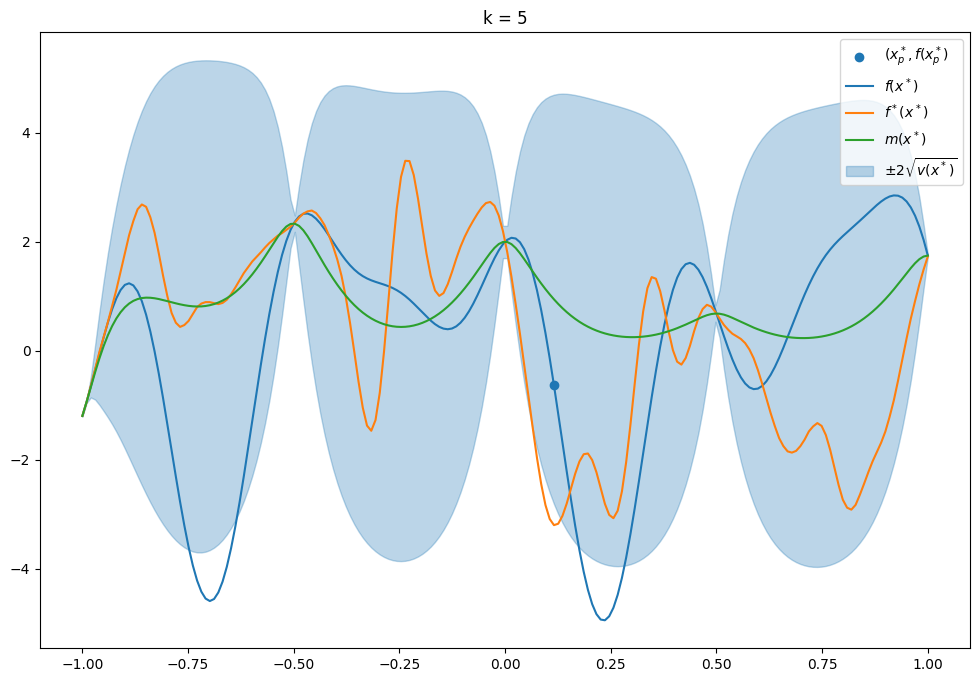

Sample: 100%|██████████| 250/250 [00:10, 23.07it/s, step size=4.19e-01, acc. prob=0.951]


-3.8635283553691235 tensor(0.2965)


Sample: 100%|██████████| 250/250 [00:07, 35.10it/s, step size=3.91e-01, acc. prob=0.874]


-3.3749000836883942 tensor(0.2864)


Sample: 100%|██████████| 250/250 [10:58,  2.64s/it, step size=4.43e-03, acc. prob=0.629]


-8.481727312892046 tensor(-0.6482)


Sample: 100%|██████████| 250/250 [06:17,  1.51s/it, step size=1.67e-02, acc. prob=0.680]


-6.423481722440384 tensor(-0.4171)


Sample: 100%|██████████| 250/250 [00:05, 46.19it/s, step size=8.42e-01, acc. prob=0.787]


-4.574545210890308 tensor(0.2462)


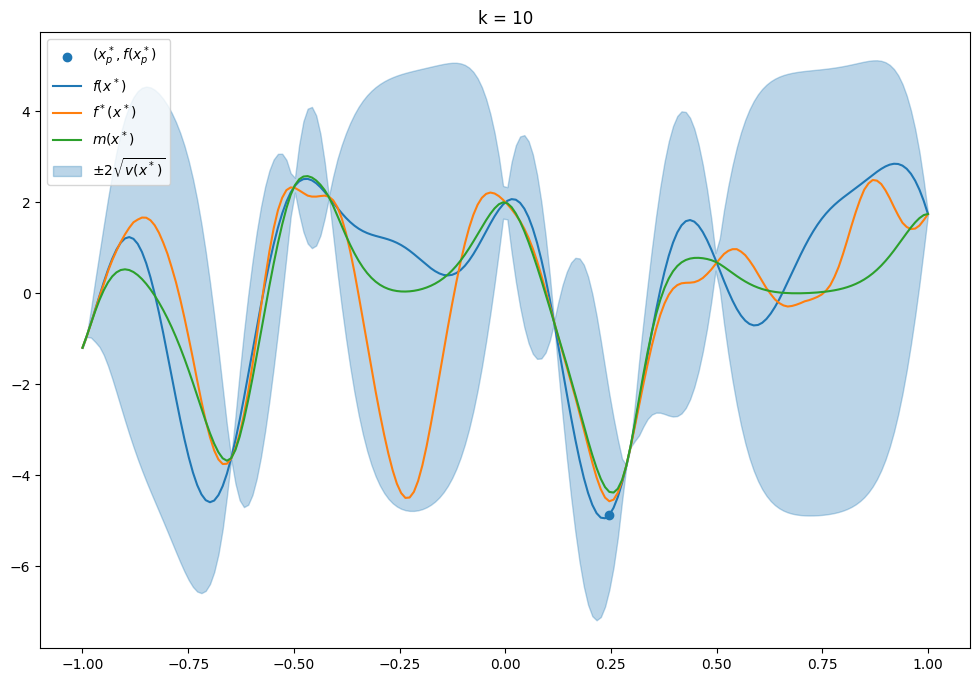

Sample: 100%|██████████| 250/250 [00:04, 53.70it/s, step size=7.79e-01, acc. prob=0.578]


In [153]:
BOA2(11)

# LCB

In [161]:
def UCB(iter, c):
    Xt = X
    yt = y
    mcmct = mcmc
    for i in range(iter):
        pyro.clear_param_store()

        # Posterior samples
        ls = mcmct.get_samples()['kernel.lengthscale']
        v = mcmct.get_samples()['kernel.variance']

        locs = []
        covs = torch.zeros(Xstar.size())
        for j in range(len(ls)):
            pyro.clear_param_store()
            kernel_temp2 = gp.kernels.RBF(input_dim=1)
            kernel_temp2.variance = v[j]
            kernel_temp2.lengthscale = ls[j]
            iter2_gpr = gp.models.GPRegression(Xt, yt, kernel_temp2, noise = noise)

            loc, cov = iter2_gpr(Xstar)
            locs.append(loc.detach().numpy())
            covs = covs + cov

        # calculate m and v
        locs = np.array(locs)
        meanOfMeans = [np.mean(locs[:,k]) for k in range(len(locs[0]))]
        variationOfMeans = np.sum((locs - meanOfMeans)**2, axis=0) / len(locs)
        meanOfVars = (covs / len(ls)).detach().numpy()
        fullVar = meanOfVars + variationOfMeans
        
        criteria = meanOfMeans - c * np.sqrt(fullVar)
        val= criteria.min()
        ind = criteria.argmin()
        print(val, ind)
        

        if i % 10 == 0:
            # Plot f, f*
            plt.subplots(figsize =(12, 8))
            plt.plot(Xstar, f(Xstar), label = "$f(x^*)$")
            plt.title(f"k = {i}, $\\kappa$ = {c}")

            # Add plot of m - c * v
            plt.plot(Xstar, criteria, label = "$m(x^*) - \\kappa * \\sqrt{v(x^*)}$")
            plt.plot(Xstar, meanOfMeans, label = "$m(x^*)$")

            plt.legend()
            plt.show()
        
        Xt = torch.cat((Xt, torch.tensor([Xstar[ind]])))
        yt = torch.cat((yt, torch.tensor([f(Xstar[ind])])))

        kernelt = gp.kernels.RBF(1)
        kernelt.variance = pyro.nn.PyroSample(varianceDist)
        kernelt.lengthscale = pyro.nn.PyroSample(lengthscaleDist)
        gprt = gp.models.GPRegression(Xt, yt, kernel, noise = noise)

        # 10 warm up steps for tuning
        pyro.clear_param_store()
        nuts_kernelt=NUTS(gprt.model, adapt_step_size=True)
        nuts_kernelt.cleanup()
        mcmct=MCMC(nuts_kernelt, num_samples=100, num_chains=1, warmup_steps=10)
        mcmct.run()

-2.4606264 13


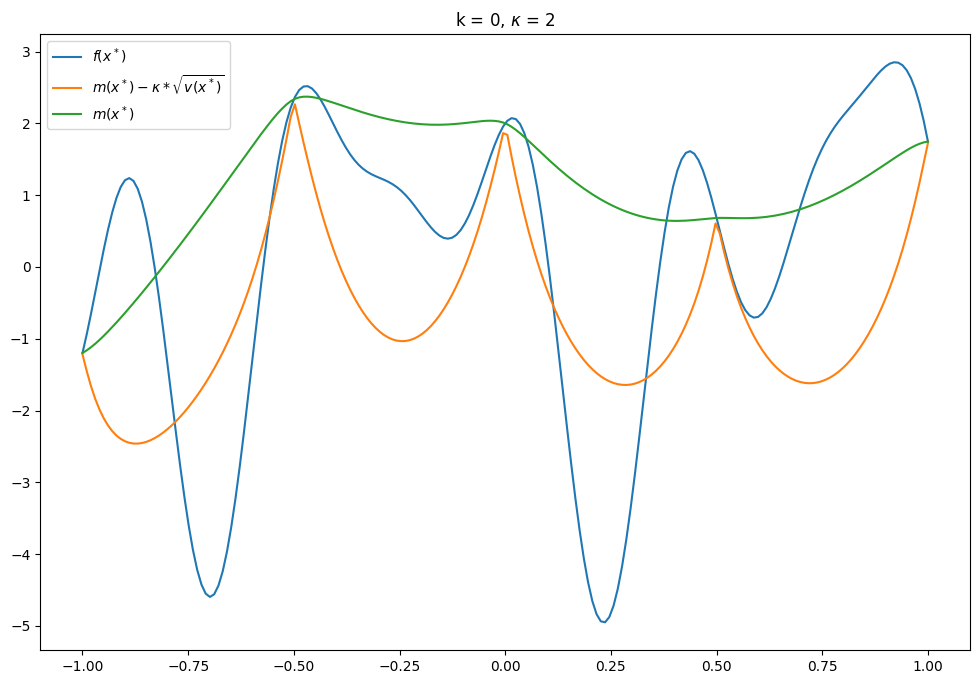

Sample: 100%|██████████| 110/110 [00:02, 43.93it/s, step size=2.90e-01, acc. prob=0.921]


-3.1332967 173


Sample: 100%|██████████| 110/110 [00:02, 50.11it/s, step size=2.76e-01, acc. prob=0.876]


-2.8680985 126


Sample: 100%|██████████| 110/110 [00:01, 68.32it/s, step size=3.70e-01, acc. prob=0.777]


-6.546692 132


Sample: 100%|██████████| 110/110 [00:02, 42.30it/s, step size=1.84e-01, acc. prob=0.943]


-7.4412684 120


Sample: 100%|██████████| 110/110 [00:05, 20.26it/s, step size=6.53e-02, acc. prob=0.992]


-5.852851 123


Sample: 100%|██████████| 110/110 [00:01, 69.10it/s, step size=2.66e-01, acc. prob=0.376]


-4.968937 123


Sample: 100%|██████████| 110/110 [00:01, 62.51it/s, step size=2.08e-01, acc. prob=0.639]


-5.1832376 122


Sample: 100%|██████████| 110/110 [00:02, 47.27it/s, step size=1.59e-01, acc. prob=0.758]


-4.9618273 123


Sample: 100%|██████████| 110/110 [00:02, 51.53it/s, step size=1.63e-01, acc. prob=0.731]


-4.95995 123


Sample: 100%|██████████| 110/110 [00:03, 35.69it/s, step size=9.84e-02, acc. prob=0.929]


-4.9587035 123


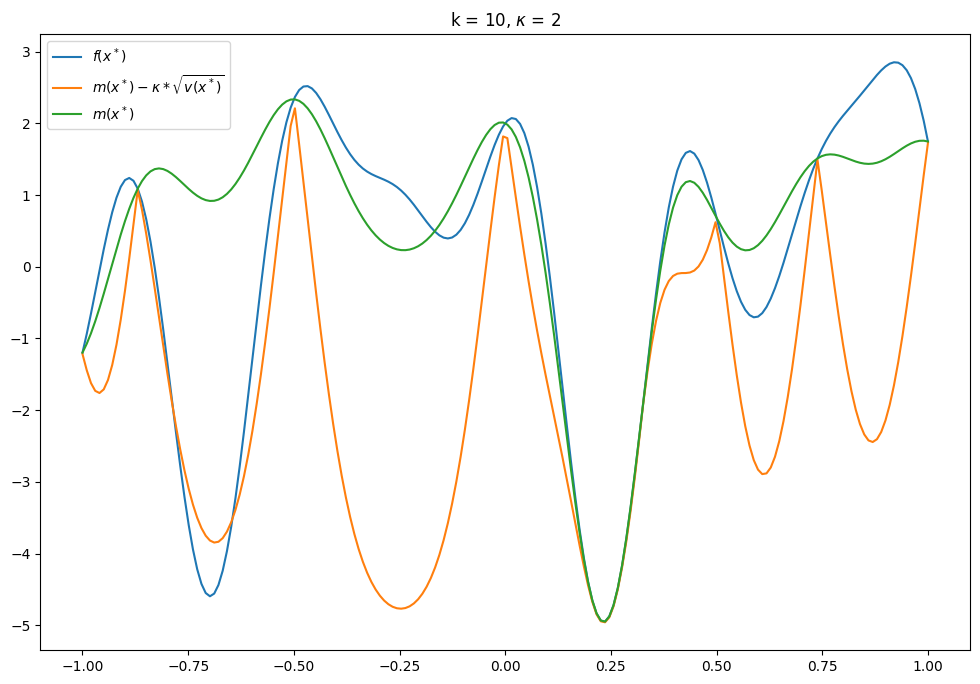

Sample: 100%|██████████| 110/110 [00:06, 17.45it/s, step size=5.38e-02, acc. prob=0.985]


-3.5127776 16


Sample:  18%|█▊        | 37/210 [13:11, 21.38s/it, step size=3.07e-01, acc. prob=0.724]


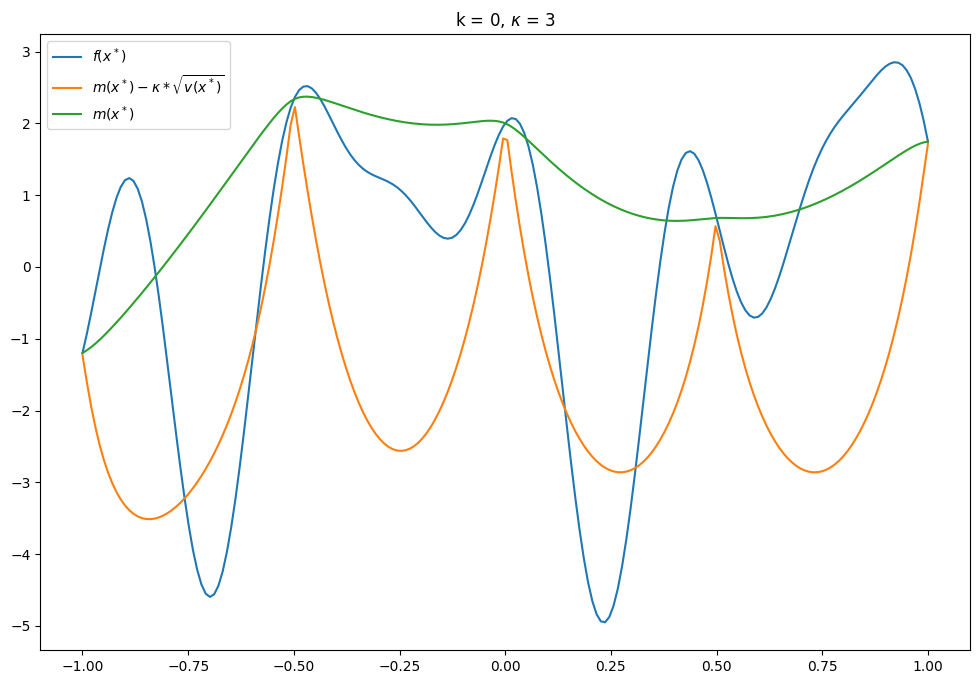

Sample: 100%|██████████| 110/110 [00:02, 48.81it/s, step size=3.17e-01, acc. prob=0.702]


-1.4289429 172


Sample: 100%|██████████| 110/110 [00:02, 52.99it/s, step size=2.49e-01, acc. prob=0.730]


-1.2281619 0


Sample: 100%|██████████| 110/110 [00:01, 69.12it/s, step size=3.33e-01, acc. prob=0.441]


-1.2194836 0


Sample: 100%|██████████| 110/110 [00:05, 20.34it/s, step size=8.94e-02, acc. prob=0.987]


-1.5494545 127


Sample: 100%|██████████| 110/110 [00:02, 39.37it/s, step size=2.05e-01, acc. prob=0.902]


-7.518761 119


Sample: 100%|██████████| 110/110 [00:02, 50.88it/s, step size=2.54e-01, acc. prob=0.835]


-7.1514235 76


Sample: 100%|██████████| 110/110 [00:01, 55.36it/s, step size=2.34e-01, acc. prob=0.786]


-6.1372423 123


Sample: 100%|██████████| 110/110 [01:15,  1.45it/s, step size=1.57e-05, acc. prob=0.542]


-5.0649033 1


Sample: 100%|██████████| 110/110 [00:03, 34.69it/s, step size=1.08e-01, acc. prob=0.945]


-5.627609 31


Sample: 100%|██████████| 110/110 [02:18,  1.26s/it, step size=2.09e-03, acc. prob=0.996]


-7.653969 37


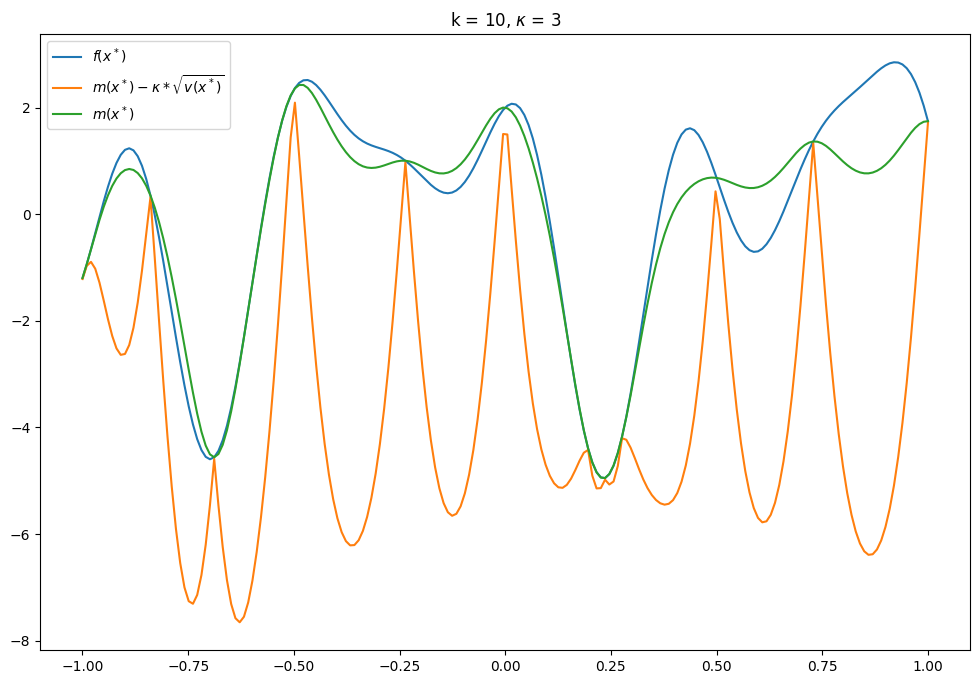

Sample: 100%|██████████| 110/110 [00:04, 25.62it/s, step size=7.71e-02, acc. prob=0.972]


In [163]:
UCB(11, 2)
UCB(11, 3)